- http://www.machinelearning.ru/wiki/images/9/9f/2015_417_DoykovNV.pdf
- https://github.com/bigartm/bigartm/blob/master/python/artm/model.py
- https://github.com/bigartm/bigartm-book/blob/4f3e2365e167a05a97129d496d8d1cce26c0cf49/applications/eurlex/Main_RU.ipynb
- https://bigartm.readthedocs.org/en/stable/formats.html
- http://www.machinelearning.ru/wiki/images/e/e3/Voron15slds.pdf

In [1]:
%matplotlib inline
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import artm
from scipy import stats
from numpy import random
from tqdm import trange
from munkres import Munkres

In [140]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
matplotlib.rcParams['text.usetex']=True
matplotlib.rcParams['text.latex.unicode']=True
matplotlib.rcParams.update({'font.size': 30})
sns.set_style(style='white') 

def plot_pyt(phi, t, logscale=False, save=None, title=None):
    if not title:
        title = 'Month distribution given @topic{0}'.format(t)
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    pyt = get_pyt(phi, t)
    ax.plot(pyt)
    if logscale:
        ax.set_yscale('log')
    plt.title(title)
    plt.xlabel('y')
    plt.ylabel('p(y $|$ @topic{0})'.format(t))
    plt.ylim(0, 1.0)
    plt.xlim(0, 147)
    plt.grid(True)
    if save:
        plt.savefig(save, format='eps', dpi=1000, bbox_inches='tight', pad_inches=0)
        
    
def get_pyt(phi, t):
    return np.nan_to_num(phi[:, t])
    
def plot_pty(phi, y):
    plt.figure()
    plt.plot(phi[y, :])
    plt.title('Topics distribution in month={0}'.format(y))
    plt.xlabel('t')
    plt.ylabel('p(t|)')
    
def plot_matrix(matrix, figsize=(20,15), xlabel='', ylabel='', title='', save=None):
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.binary)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.colorbar()
    if save:
        plt.savefig(save, format='eps', dpi=1000, bbox_inches='tight', pad_inches=0)
    print np.any(np.isnan(matrix))
    
def get_phi_timestamps(model):
    phi_m = model.get_phi(class_ids=[timestamps_class])
    phi_m.index = phi_m.index.map(lambda x: int(x))
    phi_m = phi_m.sort_index()
    return phi_m.values

def get_corr_matrix(phi):
    df = pd.DataFrame(phi)
    return df.corr()

def plot_corr_matrix(matrix, save=None):
    sns.set(style="white")
    f, ax = plt.subplots(figsize=(20, 10))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(matrix, cmap='Blues', vmin=0.0,
            square=True, xticklabels=2, yticklabels=2,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
    ax.set_title('Topic-topic correlation matrix')
    if save:
        plt.savefig(save, format='eps', dpi=1000, bbox_inches='tight', pad_inches=0)
    
def print_topics(topic_names=None, weights=False):
    if topic_names is None:
        topic_names = model.topic_names
    for topic_name in topic_names:
        print topic_name + ': ',
        tokens = model.score_tracker['TopTokensScore'].last_topic_info[topic_name].tokens
        if weights:
            weights = model.score_tracker['TopTokensScore'].last_topic_info[topic_name].weights
            for token, weight in zip(tokens, weights):
                print "({0}, {1:.3f}), ".format(token, weight),
            print
        else:
            print ', '.join(tokens)
        print

def print_measures(scores, many=False):
    if many:
        sparsityPhi = np.mean(map(lambda x: x['SparsityPhi'][-1], scores))
        sparsityTheta = np.mean(map(lambda x: x['SparsityTheta'][-1], scores))
        kernelContrast = np.mean(map(lambda x: x['KernelContrast'][-1], scores))
        kernelPurity = np.mean(map(lambda x: x['KernelPurity'][-1], scores))
        perp = np.mean(map(lambda x: x['Perplexity'][-1], scores))
    else:
        sparsityPhi = scores['SparsityPhi'][-1]
        sparsityTheta = scores['SparsityTheta'][-1]
        kernelContrast = scores['KernelContrast'][-1]
        kernelPurity = scores['KernelPurity'][-1]
        perp = scores['Perplexity'][-1]
    print 'Sparsity Phi: {0:.3f}'.format(sparsityPhi)

    print 'Sparsity Theta: {0:.3f}'.format(sparsityTheta)

    print 'Kernel contrast: {0:.3f}'.format(kernelContrast)

    print 'Kernel purity: {0:.3f}'.format(kernelPurity)

    print 'Perplexity: {0:.3f}'.format(perp)
    
def print_scores(scores, save=None, many=False):
    print_measures(scores, many)
    
    plt.figure()
    phi, theta = None, None
    if many:
        for scores_dict in scores:    
            phi, = plt.plot(scores_dict['SparsityPhi'], 'r--', linewidth=2, alpha=0.3)
            theta, = plt.plot(scores_dict['SparsityTheta'], 'b--', linewidth=2, alpha=0.3)
    else:
        phi, = plt.plot(scores['SparsityPhi'], 'r--', linewidth=2)
        theta, = plt.plot(scores['SparsityTheta'], 'b--', linewidth=2)
    plt.xlabel('Iterations count')
    plt.ylabel('Sparsity')
    plt.legend([phi, theta], ['Phi sparsity', 'Theta sparsity'])
    plt.grid(True)
    if save:
        plt.savefig(save+"_sparsity.eps", format='pdf', dpi=1000,
                    bbox_inches='tight', pad_inches=0)
    plt.show()
    
    plt.figure()
    contrast, purity = None, None
    if many:
        for scores_dict in scores:
            contrast, = plt.plot(scores_dict['KernelContrast'], 'r', linewidth=2, alpha=0.3)
            purity, = plt.plot(scores_dict['KernelPurity'], 'b', linewidth=2, alpha=0.3)
    else:
        contrast, = plt.plot(scores['KernelContrast'], 'r', linewidth=2)
        purity, = plt.plot(scores['KernelPurity'], 'b', linewidth=2)
    plt.xlabel('Iterations count')
    plt.ylabel('Contrast/Purity')
    plt.grid(True)
    plt.legend([contrast, purity], ['Average contrast', 'Average purity'])
    if save:
        plt.savefig(save+"_contrast_purity.eps", format='pdf', dpi=1000,
                    bbox_inches='tight', pad_inches=0)
    plt.show()
    
    plt.figure()
    perp = None
    if many:
        for scores_dict in scores:
            perp, = plt.plot(scores_dict['Perplexity'][1:], 'b--', linewidth=2, alpha=0.3)
    else:
        perp, = plt.plot(scores['Perplexity'][1:], 'b--', linewidth=2)
    plt.xlabel('Iterations count')
    plt.ylabel('Perplexity')
    plt.xlim(1)
    plt.legend([perp], ['Model perplexity'])
    plt.grid(True)
    if save:
        plt.savefig(save+"_perplexity.eps", format='pdf', dpi=1000,
                    bbox_inches='tight', pad_inches=0)
    plt.show()
    
def zeroes_left_right(pyt, eps=1e-3):
    mask = np.nan_to_num(pyt) > eps
    left_nonzero_idx = 0
    right_nonzeros_idx = mask.size-1
    while left_nonzero_idx < mask.size and not mask[left_nonzero_idx]:
        left_nonzero_idx += 1
    while right_nonzeros_idx >= 0 and not mask[right_nonzeros_idx]:
        right_nonzeros_idx -= 1
    if left_nonzero_idx == mask.size-1:
        return 1.0
    else:
        return float(left_nonzero_idx + mask.size-right_nonzeros_idx) / mask.size

def std(pyt):
    return np.std(pyt)

def delta_roc(pyt):
    points = []
    for delta in xrange(1, pyt.size):
        max_dens = 0
        for pos in xrange(pyt.size-delta):
            density = np.sum(pyt[pos:pos+delta])
            if density > max_dens:
                max_dens = density
        points.append((delta, 1.0-max_dens))
    return np.array(points)

def auc_delta_roc(delta_roc):
    s = 0
    return np.sum(map(lambda x: x[1], delta_roc))

# plot_delta_roc(get_pyt(phi_m, 13), save='one_peak_delta_auc_roc.eps')
def plot_delta_roc(pyt, save=None):
    roc = delta_roc(pyt)
    plt.title("AUC = {0}".format(auc_delta_roc(roc)))
    roc = np.array([x[1] for x in roc])
    assert np.arange(1, roc.size+1).shape == roc.shape
    plt.plot(np.arange(1, roc.size+1), roc)
    plt.grid(True)
    plt.xlim(0, 147)
    plt.ylim(ymin=0)
    if save:
        plt.savefig(save, format='eps', dpi=1000, bbox_inches='tight', pad_inches=0)

def variability(pyt):
    res = 0
    for i in xrange(1, pyt.size):
        res += np.abs(pyt[i]**.5-pyt[i-1]**.5)
    return res
    
def print_correlation_statistics(phi):
    corr_m = get_corr_matrix(phi)
    N = corr_m.shape[0]
    min_corr = corr_m.min().min()
    max_corr = (corr_m-np.eye(N)).max().max()
    avg_corr = (corr_m.sum().sum()-N)/(N*(N-1))
    print "Min. Corr.", min_corr
    print "Max. Corr.", max_corr
    print "Avg. Corr.", avg_corr
    return min_corr, max_corr, avg_corr

def sparsity(matrix):
    zeros = (matrix < 1e-5).sum()
    return float(zeros)/(matrix.shape[0] * matrix.shape[1])

def hellinger_dist(p1, p2):
    return np.sqrt(np.sum((np.sqrt(p1)-np.sqrt(p2))**2)/2)

def corr(p1, p2):
    return np.sum(p1 * p2)

def cut_and_normalize(distr, top=20):
    res = distr[np.argsort(-distr)[:top]]
    if np.sum(res) != 0:
        res = res/np.sum(res)
    return res

def find_perm(phi1, phi2):
    num_topics = phi1.shape[1]
    assert phi1.shape[1] == phi2.shape[1]
    T = np.zeros((num_topics, num_topics))
    for i in xrange(num_topics):
        for j in xrange(i, num_topics):
            topic1 = cut_and_normalize(phi1[:, i])
            topic2 = cut_and_normalize(phi2[:, j])
            dist = hellinger_dist(topic1, topic2)
            T[i,j] = T[j,i] = dist
    m = Munkres()
    indexes = m.compute(T.copy())
    return indexes, T

In [3]:
timestamps_class = "@timestamps_class"
tokens_class = "@default_class"

data_folder = "batches"

In [4]:
numpy_rng = random.RandomState(1234)

In [119]:
def learn_model(params, random=False):
    num_topics = params['num_topics']
    num_back_topics = params['num_back_topics']
    num_collection_passes = params['num_collection_passes']
    num_document_passes = params['num_document_passes']
    timestamps_class_weight = params['TimestampsClassWeight']
    
    sparse_theta_tau      = [0.00] * (num_collection_passes-3) + [-0.9] * 3
    sparse_phi_tau        = [0.00] * (num_collection_passes-3) + [-0.9] * 3
    
    all_topic_names = ['@topic_'+str(i) for i in xrange(num_topics)]
    spec_topics = all_topic_names[:-num_back_topics]
    back_topics = all_topic_names[-num_back_topics:]
    
    batch_vectorizer = None
    if len(glob.glob(os.path.join('batches', '*.batch'))) < 1:
        batch_vectorizer = artm.BatchVectorizer(data_path='usa_ts', data_format='bow_uci',
                                                collection_name='usa_ts', target_folder='batches')
    else:
        batch_vectorizer = artm.BatchVectorizer(data_path='batches', data_format='batches')

    model = artm.ARTM(num_topics=num_topics)

    if not os.path.isfile('batches/dictionary.dict'):
        model.gather_dictionary('dictionary', batch_vectorizer.data_path)
        model.save_dictionary(dictionary_name='dictionary', dictionary_path='batches/dictionary.dict')

    model.load_dictionary(dictionary_name='dictionary', dictionary_path='batches/dictionary.dict')

    model.load_dictionary(dictionary_name='dictionary', dictionary_path=os.path.join('batches', 'dictionary.dict'))
    
    if random:
        model.initialize(dictionary_name='dictionary', seed=numpy_rng.randint(2**16))
    else:
        model.initialize(dictionary_name='dictionary')
    
    # Balance classes.
    model.class_ids = {tokens_class: 1.0, timestamps_class: timestamps_class_weight}
    
    # Add regularizers.
    model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhiRegularizer',
                                                           tau=params['SparsePhiRegularizer'],
                                                           topic_names=spec_topics))
    model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SmoothPhiRegularizer',
                                                           tau=params['SmoothPhiRegularizer'],
                                                           topic_names=back_topics))

    model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhiRegularizer',
                                                           tau=params['DecorrelatorPhiRegularizer'],
                                                           topic_names=spec_topics,
                                                           class_ids=[tokens_class]))
    model.regularizers.add(artm.TopicSelectionThetaRegularizer(name='TopicSelectionThetaRegularizer',
                                                               tau=params['TopicSelectionThetaRegularizer'],
                                                               topic_names=spec_topics))

    model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseThetaRegularizer',
                                                             tau=params['SparseThetaRegularizer'],
                                                             topic_names=spec_topics))
    model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SmoothThetaRegularizer',
                                                             tau=params['SmoothThetaRegularizer'],
                                                             topic_names=back_topics))
    
    
    model.regularizers.add(artm.LabelRegularizationPhiRegularizer(name='LabelSparsePsiRegularizer',
                                                                  tau=params['LabelSparsePsiRegularizer'],
                                                                  topic_names=spec_topics,
                                                                  class_ids=[timestamps_class]))
    model.regularizers.add(artm.LabelRegularizationPhiRegularizer(name='LabelSmoothPsiRegularizer',
                                                                  tau=params['LabelSmoothPsiRegularizer'],
                                                                  topic_names=back_topics,
                                                                  class_ids=[timestamps_class]))
    
    # Add scores.
    model.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                               use_unigram_document_model=False,
                                               dictionary_name='dictionary'))
    model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore', topic_names=spec_topics))
    model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore', topic_names=spec_topics))
    model.scores.add(artm.TopicKernelScore(name='TopicKernelScore',
                                           probability_mass_threshold=0.25,
                                           topic_names=spec_topics))
    model.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=8))
    
    scores = {
        "SparsityPhi": [],
        "SparsityTheta": [],
        "KernelContrast": [],
        "KernelPurity": [],
        "Perplexity": [],
        "Coherence": []
    }
    thetas = []
    phis = []
    psis = []
    for iter in xrange(num_collection_passes):
        print 'Start processing iteration #' + str(iter) + '...'
        model.regularizers['SparsePhiRegularizer'].tau = sparse_phi_tau[iter]
        model.regularizers['SparseThetaRegularizer'].tau = sparse_theta_tau[iter]
        model.fit_offline(batch_vectorizer=batch_vectorizer, 
                          num_collection_passes=1,
                          num_document_passes=num_document_passes)    
        scores['SparsityPhi'].append(model.score_tracker['SparsityPhiScore'].last_value)
        scores['SparsityTheta'].append(model.score_tracker['SparsityThetaScore'].last_value)
        scores['KernelContrast'].append(model.score_tracker['TopicKernelScore'].last_average_contrast)
        scores['KernelPurity'].append(model.score_tracker['TopicKernelScore'].last_average_purity)
        scores['Perplexity'].append(model.score_tracker['PerplexityScore'].last_value)
        scores['Coherence'].append(model.score_tracker['TopicKernelScore'].last_average_coherence)
        if (scores['SparsityPhi'][-1] == 1.0 or scores['SparsityTheta'][-1] == 1.0):
            print "SPARSE"
        thetas.append(model.get_theta())
        phis.append(model.get_phi(class_ids=[tokens_class]))
        psis.append(get_phi_timestamps(model))
    
    return model, scores, thetas, phis, psis

### LDA TODO
~~1. Topics examples~~
### ARTM+TIME TODO
1. ~~Distributions over time (along with delta-auc) for topic examples~~
2. ~~eventness topics examples~~
3. ~~noneventness topics examples~~
### STABILITY EXPERIMENT
1. hellinger distance -- top20 instead of top5 words (sucks or not?)
2. "iterations" -> "launches
### DOC
1. CONCLUSION -> MORE
2. INTRO -> LESS
3. "CLASSICAL METRICS" -> "METRICS"


In [120]:
params = {
    'num_topics': 100,
    'num_back_topics': 10,
    'num_collection_passes': 20,
    'num_document_passes': 1,
    'SparsePhiRegularizer': -0.90,
    'SmoothPhiRegularizer': 0.90,
    'SparseThetaRegularizer': -0.1,
    'SmoothThetaRegularizer': 0.1,
    'DecorrelatorPhiRegularizer': 15.0,
    'TopicSelectionThetaRegularizer': 0.0,
    'LabelSparsePsiRegularizer': -0.05,
    'LabelSmoothPsiRegularizer': 0.0,
    'TimestampsClassWeight': 5
}

# params = {
#     'num_topics': 100,
#     'num_back_topics': 0,
#     'num_collection_passes': 20,
#     'num_document_passes': 1,
#     'SparsePhiRegularizer': 0.0,
#     'SmoothPhiRegularizer': 1,
#     'SparseThetaRegularizer': 0.0,
#     'SmoothThetaRegularizer': 0.0,
#     'DecorrelatorPhiRegularizer': 0.0,
#     'TopicSelectionThetaRegularizer': 0.0,
#     'LabelSparsePsiRegularizer': 0,
#     'LabelSmoothPsiRegularizer': 0,
#     'TimestampsClassWeight': 0
# }

# model, scores, thetas, phis, psis = learn_model(params)

Sparsity Phi: 0.000
Sparsity Theta: 0.004
Kernel contrast: 0.410
Kernel purity: 0.114
Perplexity: 1071.323


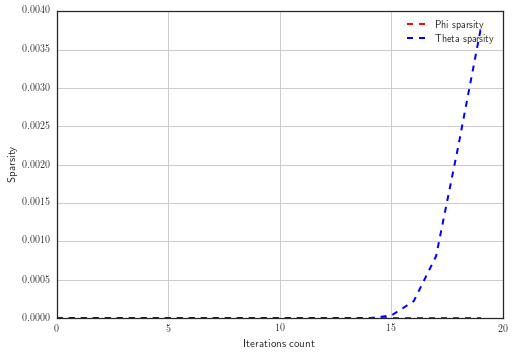

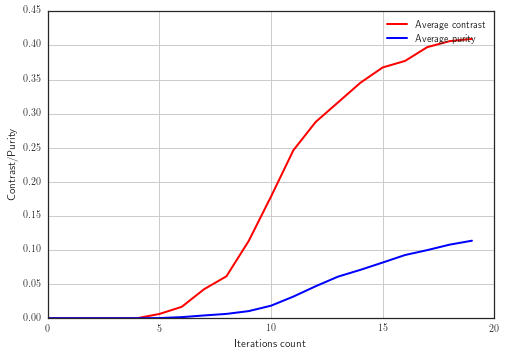

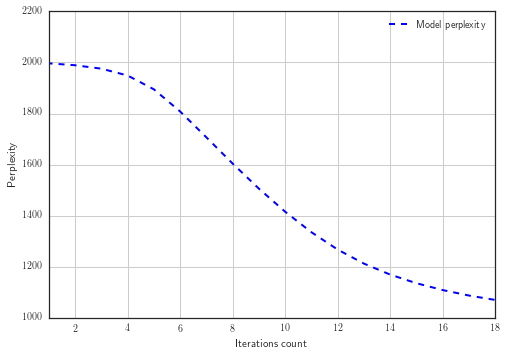

In [93]:
print_scores(scores, save='LDA', many=False)

In [121]:
m_s = []
for i in trange(25):
    model, scores, _, _, _ = learn_model(params, random=True)
    m_s.append((model, scores))

  0%|          | 0/25 [00:00<?, ?it/s]

Start processing iteration #0...
Start processing iteration #1...
Start processing iteration #2...
Start processing iteration #3...
Start processing iteration #4...
Start processing iteration #5...
Start processing iteration #6...
Start processing iteration #7...
Start processing iteration #8...
Start processing iteration #9...
Start processing iteration #10...
Start processing iteration #11...
Start processing iteration #12...
Start processing iteration #13...
Start processing iteration #14...
Start processing iteration #15...
Start processing iteration #16...
Start processing iteration #17...
Start processing iteration #18...
Start processing iteration #19...


  4%|▍         | 1/25 [06:35<2:38:20, 395.84s/it]

Start processing iteration #0...
Start processing iteration #1...
Start processing iteration #2...
Start processing iteration #3...
Start processing iteration #4...
Start processing iteration #5...
Start processing iteration #6...
Start processing iteration #7...
Start processing iteration #8...
Start processing iteration #9...
Start processing iteration #10...
Start processing iteration #11...
Start processing iteration #12...
Start processing iteration #13...
Start processing iteration #14...
Start processing iteration #15...
Start processing iteration #16...
Start processing iteration #17...
Start processing iteration #18...
Start processing iteration #19...


  8%|▊         | 2/25 [10:16<2:11:34, 343.23s/it]

Start processing iteration #0...
Start processing iteration #1...
Start processing iteration #2...
Start processing iteration #3...
Start processing iteration #4...
Start processing iteration #5...
Start processing iteration #6...
Start processing iteration #7...
Start processing iteration #8...
Start processing iteration #9...
Start processing iteration #10...
Start processing iteration #11...
Start processing iteration #12...
Start processing iteration #13...
Start processing iteration #14...
Start processing iteration #15...
Start processing iteration #16...
Start processing iteration #17...
Start processing iteration #18...
Start processing iteration #19...


 12%|█▏        | 3/25 [13:20<1:48:22, 295.57s/it]

Start processing iteration #0...
Start processing iteration #1...
Start processing iteration #2...
Start processing iteration #3...
Start processing iteration #4...
Start processing iteration #5...
Start processing iteration #6...
Start processing iteration #7...
Start processing iteration #8...
Start processing iteration #9...
Start processing iteration #10...
Start processing iteration #11...
Start processing iteration #12...
Start processing iteration #13...
Start processing iteration #14...
Start processing iteration #15...
Start processing iteration #16...
Start processing iteration #17...
Start processing iteration #18...
Start processing iteration #19...


 16%|█▌        | 4/25 [16:37<1:33:06, 266.03s/it]

Start processing iteration #0...
Start processing iteration #1...
Start processing iteration #2...
Start processing iteration #3...
Start processing iteration #4...
Start processing iteration #5...
Start processing iteration #6...
Start processing iteration #7...
Start processing iteration #8...
Start processing iteration #9...
Start processing iteration #10...
Start processing iteration #11...
Start processing iteration #12...
Start processing iteration #13...
Start processing iteration #14...
Start processing iteration #15...
Start processing iteration #16...
Start processing iteration #17...
Start processing iteration #18...
Start processing iteration #19...


 20%|██        | 5/25 [19:46<1:20:57, 242.87s/it]

Start processing iteration #0...
Start processing iteration #1...
Start processing iteration #2...
Start processing iteration #3...
Start processing iteration #4...
Start processing iteration #5...
Start processing iteration #6...
Start processing iteration #7...
Start processing iteration #8...
Start processing iteration #9...
Start processing iteration #10...
Start processing iteration #11...
Start processing iteration #12...
Start processing iteration #13...
Start processing iteration #14...
Start processing iteration #15...
Start processing iteration #16...
Start processing iteration #17...
Start processing iteration #18...
Start processing iteration #19...


 24%|██▍       | 6/25 [23:08<1:13:01, 230.61s/it]

Start processing iteration #0...
Start processing iteration #1...
Start processing iteration #2...
Start processing iteration #3...
Start processing iteration #4...
Start processing iteration #5...
Start processing iteration #6...
Start processing iteration #7...
Start processing iteration #8...
Start processing iteration #9...
Start processing iteration #10...
Start processing iteration #11...
Start processing iteration #12...
Start processing iteration #13...
Start processing iteration #14...
Start processing iteration #15...
Start processing iteration #16...
Start processing iteration #17...
Start processing iteration #18...
Start processing iteration #19...


 28%|██▊       | 7/25 [26:30<1:06:34, 221.93s/it]

Start processing iteration #0...
Start processing iteration #1...
Start processing iteration #2...
Start processing iteration #3...
Start processing iteration #4...
Start processing iteration #5...
Start processing iteration #6...
Start processing iteration #7...
Start processing iteration #8...
Start processing iteration #9...
Start processing iteration #10...
Start processing iteration #11...
Start processing iteration #12...
Start processing iteration #13...
Start processing iteration #14...
Start processing iteration #15...
Start processing iteration #16...
Start processing iteration #17...
Start processing iteration #18...
Start processing iteration #19...


 32%|███▏      | 8/25 [30:05<1:02:18, 219.91s/it]

Start processing iteration #0...
Start processing iteration #1...
Start processing iteration #2...
Start processing iteration #3...
Start processing iteration #4...
Start processing iteration #5...
Start processing iteration #6...
Start processing iteration #7...
Start processing iteration #8...
Start processing iteration #9...
Start processing iteration #10...
Start processing iteration #11...
Start processing iteration #12...
Start processing iteration #13...
Start processing iteration #14...
Start processing iteration #15...
Start processing iteration #16...
Start processing iteration #17...
Start processing iteration #18...
Start processing iteration #19...


 36%|███▌      | 9/25 [34:12<1:00:47, 227.95s/it]

Start processing iteration #0...
Start processing iteration #1...
Start processing iteration #2...
Start processing iteration #3...
Start processing iteration #4...
Start processing iteration #5...
Start processing iteration #6...
Start processing iteration #7...
Start processing iteration #8...
Start processing iteration #9...
Start processing iteration #10...
Start processing iteration #11...
Start processing iteration #12...
Start processing iteration #13...
Start processing iteration #14...
Start processing iteration #15...
Start processing iteration #16...
Start processing iteration #17...
Start processing iteration #18...
Start processing iteration #19...


 40%|████      | 10/25 [38:17<58:15, 233.04s/it] 

Start processing iteration #0...
Start processing iteration #1...
Start processing iteration #2...
Start processing iteration #3...
Start processing iteration #4...
Start processing iteration #5...
Start processing iteration #6...
Start processing iteration #7...
Start processing iteration #8...
Start processing iteration #9...
Start processing iteration #10...
Start processing iteration #11...
Start processing iteration #12...
Start processing iteration #13...
Start processing iteration #14...
Start processing iteration #15...
Start processing iteration #16...
Start processing iteration #17...
Start processing iteration #18...
Start processing iteration #19...


 44%|████▍     | 11/25 [42:10<54:23, 233.10s/it]

Start processing iteration #0...
Start processing iteration #1...
Start processing iteration #2...
Start processing iteration #3...
Start processing iteration #4...
Start processing iteration #5...
Start processing iteration #6...
Start processing iteration #7...
Start processing iteration #8...
Start processing iteration #9...
Start processing iteration #10...
Start processing iteration #11...
Start processing iteration #12...
Start processing iteration #13...
Start processing iteration #14...
Start processing iteration #15...
Start processing iteration #16...
Start processing iteration #17...
Start processing iteration #18...
Start processing iteration #19...


 48%|████▊     | 12/25 [45:40<48:59, 226.14s/it]

Start processing iteration #0...
Start processing iteration #1...
Start processing iteration #2...
Start processing iteration #3...
Start processing iteration #4...
Start processing iteration #5...
Start processing iteration #6...
Start processing iteration #7...
Start processing iteration #8...
Start processing iteration #9...
Start processing iteration #10...
Start processing iteration #11...
Start processing iteration #12...
Start processing iteration #13...
Start processing iteration #14...
Start processing iteration #15...
Start processing iteration #16...
Start processing iteration #17...
Start processing iteration #18...
Start processing iteration #19...


 52%|█████▏    | 13/25 [49:05<43:59, 219.96s/it]

Start processing iteration #0...
Start processing iteration #1...
Start processing iteration #2...
Start processing iteration #3...
Start processing iteration #4...
Start processing iteration #5...
Start processing iteration #6...
Start processing iteration #7...
Start processing iteration #8...
Start processing iteration #9...
Start processing iteration #10...
Start processing iteration #11...
Start processing iteration #12...
Start processing iteration #13...
Start processing iteration #14...
Start processing iteration #15...
Start processing iteration #16...
Start processing iteration #17...
Start processing iteration #18...
Start processing iteration #19...


 56%|█████▌    | 14/25 [52:26<39:15, 214.11s/it]

Start processing iteration #0...
Start processing iteration #1...
Start processing iteration #2...
Start processing iteration #3...
Start processing iteration #4...
Start processing iteration #5...
Start processing iteration #6...
Start processing iteration #7...
Start processing iteration #8...
Start processing iteration #9...
Start processing iteration #10...
Start processing iteration #11...
Start processing iteration #12...
Start processing iteration #13...
Start processing iteration #14...
Start processing iteration #15...
Start processing iteration #16...
Start processing iteration #17...
Start processing iteration #18...
Start processing iteration #19...


 60%|██████    | 15/25 [56:44<37:52, 227.30s/it]

Start processing iteration #0...
Start processing iteration #1...
Start processing iteration #2...
Start processing iteration #3...
Start processing iteration #4...
Start processing iteration #5...
Start processing iteration #6...
Start processing iteration #7...
Start processing iteration #8...
Start processing iteration #9...
Start processing iteration #10...
Start processing iteration #11...
Start processing iteration #12...
Start processing iteration #13...
Start processing iteration #14...
Start processing iteration #15...
Start processing iteration #16...
Start processing iteration #17...
SPARSE
Start processing iteration #18...
SPARSE
Start processing iteration #19...
SPARSE


 64%|██████▍   | 16/25 [1:00:41<34:32, 230.27s/it]

Start processing iteration #0...
Start processing iteration #1...
Start processing iteration #2...
Start processing iteration #3...
Start processing iteration #4...
Start processing iteration #5...
Start processing iteration #6...
Start processing iteration #7...
Start processing iteration #8...
Start processing iteration #9...
Start processing iteration #10...
Start processing iteration #11...
Start processing iteration #12...
Start processing iteration #13...
Start processing iteration #14...
Start processing iteration #15...
Start processing iteration #16...
Start processing iteration #17...
Start processing iteration #18...
Start processing iteration #19...


 68%|██████▊   | 17/25 [1:04:31<30:42, 230.27s/it]

Start processing iteration #0...
Start processing iteration #1...
Start processing iteration #2...
Start processing iteration #3...
Start processing iteration #4...
Start processing iteration #5...
Start processing iteration #6...
Start processing iteration #7...
Start processing iteration #8...
Start processing iteration #9...
Start processing iteration #10...
Start processing iteration #11...
Start processing iteration #12...
Start processing iteration #13...
Start processing iteration #14...
Start processing iteration #15...
SPARSE
Start processing iteration #16...
SPARSE
Start processing iteration #17...
SPARSE
Start processing iteration #18...
SPARSE
Start processing iteration #19...
SPARSE


 72%|███████▏  | 18/25 [1:08:25<26:59, 231.30s/it]

Start processing iteration #0...
Start processing iteration #1...
Start processing iteration #2...
Start processing iteration #3...
Start processing iteration #4...
Start processing iteration #5...
Start processing iteration #6...
Start processing iteration #7...
Start processing iteration #8...
Start processing iteration #9...
Start processing iteration #10...
Start processing iteration #11...
Start processing iteration #12...
Start processing iteration #13...
Start processing iteration #14...
Start processing iteration #15...
Start processing iteration #16...
Start processing iteration #17...
Start processing iteration #18...
Start processing iteration #19...


 76%|███████▌  | 19/25 [1:12:46<24:00, 240.08s/it]

Start processing iteration #0...
Start processing iteration #1...
Start processing iteration #2...
Start processing iteration #3...
Start processing iteration #4...
Start processing iteration #5...
Start processing iteration #6...
Start processing iteration #7...
Start processing iteration #8...
Start processing iteration #9...
Start processing iteration #10...
Start processing iteration #11...
Start processing iteration #12...
Start processing iteration #13...
Start processing iteration #14...
Start processing iteration #15...
Start processing iteration #16...
Start processing iteration #17...
Start processing iteration #18...
Start processing iteration #19...


 80%|████████  | 20/25 [1:16:43<19:56, 239.23s/it]

Start processing iteration #0...
Start processing iteration #1...
Start processing iteration #2...
Start processing iteration #3...
Start processing iteration #4...
Start processing iteration #5...
Start processing iteration #6...
Start processing iteration #7...
Start processing iteration #8...
Start processing iteration #9...
Start processing iteration #10...
Start processing iteration #11...
Start processing iteration #12...
Start processing iteration #13...
Start processing iteration #14...
Start processing iteration #15...
Start processing iteration #16...
Start processing iteration #17...
Start processing iteration #18...
Start processing iteration #19...


 84%|████████▍ | 21/25 [1:20:23<15:33, 233.46s/it]

Start processing iteration #0...
Start processing iteration #1...
Start processing iteration #2...
Start processing iteration #3...
Start processing iteration #4...
Start processing iteration #5...
Start processing iteration #6...
Start processing iteration #7...
Start processing iteration #8...
Start processing iteration #9...
Start processing iteration #10...
Start processing iteration #11...
Start processing iteration #12...
Start processing iteration #13...
Start processing iteration #14...
Start processing iteration #15...
Start processing iteration #16...
Start processing iteration #17...
Start processing iteration #18...
Start processing iteration #19...
SPARSE


 88%|████████▊ | 22/25 [1:23:52<11:18, 226.14s/it]

Start processing iteration #0...
Start processing iteration #1...
Start processing iteration #2...
Start processing iteration #3...
Start processing iteration #4...
Start processing iteration #5...
Start processing iteration #6...
Start processing iteration #7...
Start processing iteration #8...
Start processing iteration #9...
Start processing iteration #10...
Start processing iteration #11...
Start processing iteration #12...
Start processing iteration #13...
Start processing iteration #14...
Start processing iteration #15...
Start processing iteration #16...
Start processing iteration #17...
SPARSE
Start processing iteration #18...
SPARSE
Start processing iteration #19...
SPARSE


 92%|█████████▏| 23/25 [1:27:15<07:18, 219.30s/it]

Start processing iteration #0...
Start processing iteration #1...
Start processing iteration #2...
Start processing iteration #3...
Start processing iteration #4...
Start processing iteration #5...
Start processing iteration #6...
Start processing iteration #7...
Start processing iteration #8...
Start processing iteration #9...
Start processing iteration #10...
Start processing iteration #11...
Start processing iteration #12...
Start processing iteration #13...
Start processing iteration #14...
Start processing iteration #15...
Start processing iteration #16...
Start processing iteration #17...
Start processing iteration #18...
Start processing iteration #19...


 96%|█████████▌| 24/25 [1:30:37<03:34, 214.00s/it]

Start processing iteration #0...
Start processing iteration #1...
Start processing iteration #2...
Start processing iteration #3...
Start processing iteration #4...
Start processing iteration #5...
Start processing iteration #6...
Start processing iteration #7...
Start processing iteration #8...
Start processing iteration #9...
Start processing iteration #10...
Start processing iteration #11...
Start processing iteration #12...
Start processing iteration #13...
Start processing iteration #14...
Start processing iteration #15...
Start processing iteration #16...
Start processing iteration #17...
Start processing iteration #18...
Start processing iteration #19...


100%|██████████| 25/25 [1:34:03<00:00, 211.69s/it]


In [122]:
phis = map(lambda x: x[0].get_phi(class_ids=[tokens_class]).values, m_s)
models = map(lambda x: x[0], m_s)

In [123]:
phi_ms = map(lambda x: x[0].get_phi(class_ids=[timestamps_class]).values, m_s)

In [124]:
phi0 = phis[0]
phi1 = phis[1]

In [125]:
indexes, T = find_perm(phi0, phi1)
cost = 0.0
for x,y in indexes:
    cost += T[x,y]

In [126]:
top = sorted([(T[x,y], (x,y)) for x,y in indexes])[:20]

In [127]:
for x,y in indexes[:20]:
    topic_name0 = "@topic_"+str(x)
    topic_name1 = "@topic_"+str(y)
    print "x =", ', '.join(models[0].score_tracker['TopTokensScore'].last_topic_info[topic_name0].tokens)
    print "y =", ', '.join(models[1].score_tracker['TopTokensScore'].last_topic_info[topic_name1].tokens)
    print "cost =", T[x, y]

x = musical, customer, ensue, walt, nongovernment, release, witness, ban
y = unite, nation, people, state, world, global, international, national
cost = 0.0361807382911
x = musical, customer, ensue, walt, nongovernment, release, witness, ban
y = country, development, help, partner, support, sector, need, more
cost = 0.0280674692847
x = customer, walt, release, witness, ban, consolidate, representative, solve
y = assistant, secretary, state, government, meet, unite, liberia, congo
cost = 0.104038286571
x = musical, customer, ensue, walt, nongovernment, release, witness, ban
y = attack, state, unite, terrorist, terrorism, government, release, information
cost = 0.0447916678333
x = musical, customer, ensue, walt, nongovernment, release, witness, ban
y = official, administration, meet, senior, burma, president, government, minister
cost = 0.0560274040302
x = mediterranean, musical, customer, ensue, walt, nongovernment, release, witness
y = thank, here, applause, much, very, laughter, great

In [128]:
costs = []

for i in xrange(1, len(phis)):
    phi = phis[i]
    indexes, T = find_perm(phi0, phi)
    cost = 0.0
    for x,y in indexes:
        cost += T[x,y]
    cost = cost/T.shape[0]
    costs.append(cost)
    print "Phi0 - Phi{0}: avg. hellinger distance = {1}".format(i, cost)

Phi0 - Phi1: avg. hellinger distance = 0.0383915450444
Phi0 - Phi2: avg. hellinger distance = 0.03926667473
Phi0 - Phi3: avg. hellinger distance = 0.0414598378573
Phi0 - Phi4: avg. hellinger distance = 0.039238601776
Phi0 - Phi5: avg. hellinger distance = 0.0365640447284
Phi0 - Phi6: avg. hellinger distance = 0.0401395532231
Phi0 - Phi7: avg. hellinger distance = 0.0386685213608
Phi0 - Phi8: avg. hellinger distance = 0.0365181307669
Phi0 - Phi9: avg. hellinger distance = 0.0386039159355
Phi0 - Phi10: avg. hellinger distance = 0.039049898977
Phi0 - Phi11: avg. hellinger distance = 0.0383838709035
Phi0 - Phi12: avg. hellinger distance = 0.0411651709791
Phi0 - Phi13: avg. hellinger distance = 0.0386619834849
Phi0 - Phi14: avg. hellinger distance = 0.0356657755908
Phi0 - Phi15: avg. hellinger distance = 0.707106762642
Phi0 - Phi16: avg. hellinger distance = 0.039368119016
Phi0 - Phi17: avg. hellinger distance = 0.707106762642
Phi0 - Phi18: avg. hellinger distance = 0.0386160407759
Phi0 - P

In [ ]:
plt.figure(figsize=figsize)
plt.title(title)
plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.binary)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.colorbar()

In [141]:
costs1 = filter(lambda x: x < 0.7, costs)
print np.mean(costs1)
print np.std(costs1)

0.0386960143303
0.00138654122506


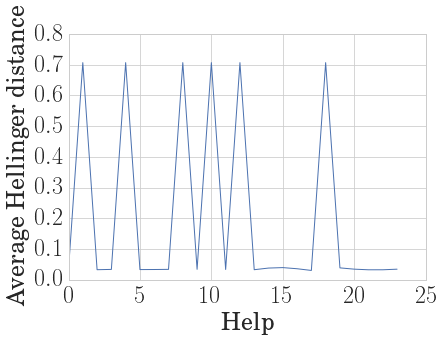

In [43]:
fontSize=24
sns.set_context("paper", font_scale=1.0, rc={'lines.linewidth': 1.0,
                                             'axes.linewidth': 1.0,
                                             'font.size': fontSize,
                                             'axes.labelsize': fontSize,
                                             'xtick.labelsize': fontSize,
                                             'ytick.labelsize': fontSize,
                                             'legend.fontsize': fontSize,
                                             'text.usetex': True
                                             })
sns.set_style("whitegrid", {'font.family': 'serif',
                            'font.serif': ['Palatino']})

plt.plot(costs)
plt.xlabel('Help')
plt.ylabel('Average Hellinger distance')
plt.grid(True)

False


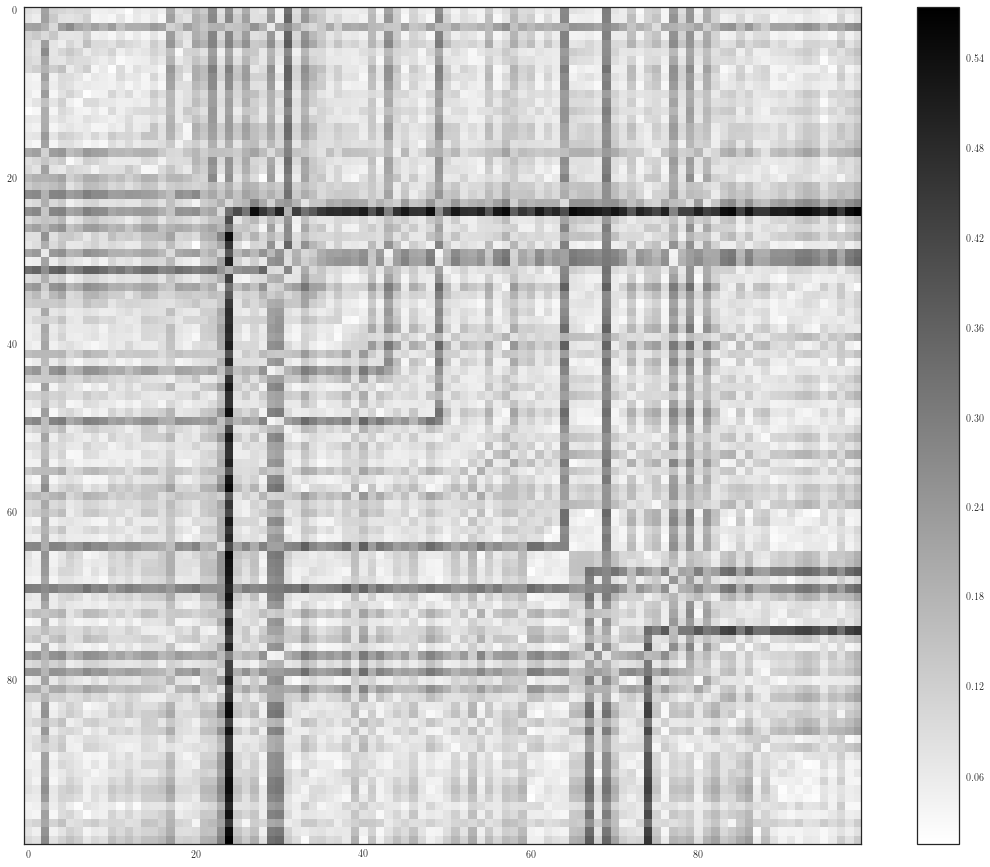

In [129]:
plot_matrix(T)

In [130]:
cost = 0.0
for x,y in indexes:
    cost += T[x,y]

In [131]:
cost

3.8933718017127545

In [133]:
scores = map(lambda x: x[1], m_s)

In [ ]:
aucs = []
for t in xrange(params['num_topics']):
    aucs.append((auc_delta_roc(delta_roc(get_pyt(phi_m, t)))/73.0, t))

Sparsity Phi: 0.843
Sparsity Theta: 0.680
Kernel contrast: 0.495
Kernel purity: 0.269
Perplexity: nan


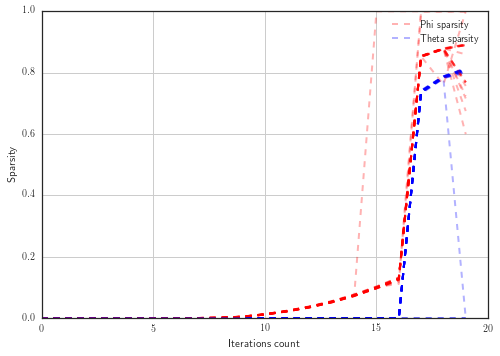

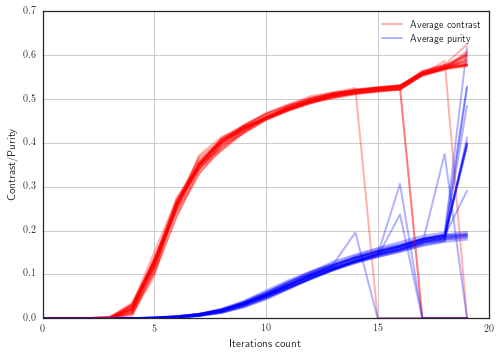

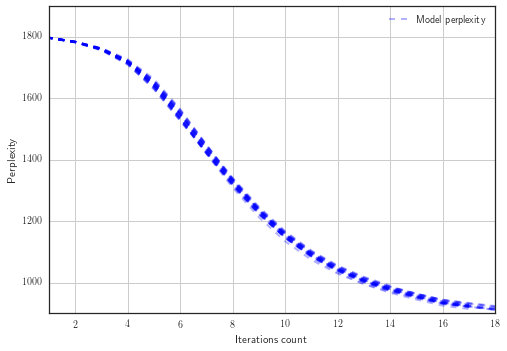

In [139]:
print_scores(scores, save='Consistency', many=True)

In [759]:
print np.all(np.sum(phis[-1], axis=0) > 1-1e-5)
print np.all(np.sum(psis[-1], axis=0) > 1-1e-5)
print np.all(np.sum(thetas[-1], axis=0) > 1-1e-5)

True
True
True


In [58]:
model = models[0]

In [58]:
# theta = model.get_theta().values
# phi = model.get_phi().values
phi_m = model.get_phi(class_ids=[timestamps_class]).values

In [25]:
sparsity(phi)

0.771042829190521

In [26]:
sparsity(theta)

0.5809582236054585

In [12]:
sparsity(phi_m)

1.0

False


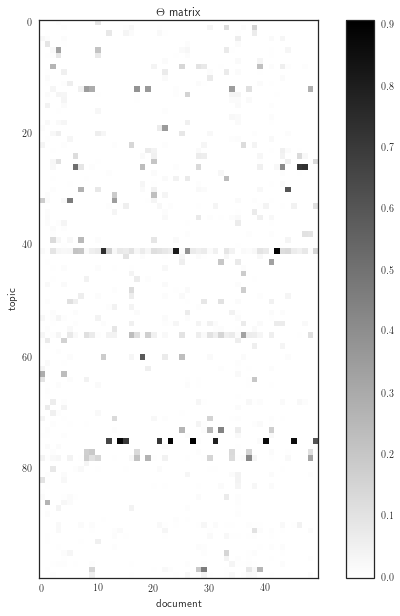

In [56]:
plot_matrix(theta[:,:50], figsize=(10,10), xlabel='document', ylabel='topic',
            title='$\Theta$ matrix', save='Temporal_Theta.eps')

False


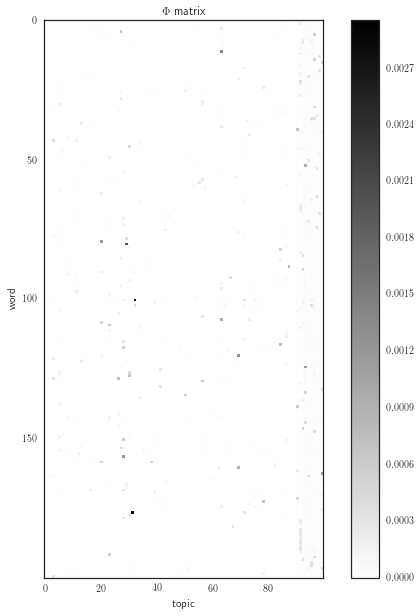

In [57]:
plot_matrix(phi[:200,:], figsize=(10,10), xlabel='topic', ylabel='word',
            title='$\Phi$ matrix', save='Temporal_Phi.eps')

In [135]:
dataset = None
for i in xrange(len(phi_ms)):
    phi_m = phi_ms[i]
    aucs = []
    for t in xrange(params['num_topics']):
        aucs.append((i, auc_delta_roc(delta_roc(get_pyt(phi_m, t)))))
    if dataset is None:
        dataset = np.array(aucs)
    else:
        dataset = np.vstack((dataset, np.array(aucs)))

In [136]:
df = pd.DataFrame(dataset, columns=['Launch', 'AUC'])

In [137]:
df['Launch'] = df['Launch'].astype(int)

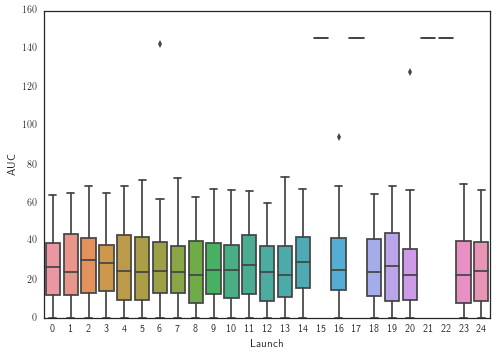

In [138]:
sns.boxplot(x='Launch', y='AUC', data=df)
plt.savefig('AUC_Boxplot.eps', format='eps', dpi=1000, bbox_inches='tight', pad_inches=0)

In [71]:
aucs = []
for t in xrange(params['num_topics']):
    aucs.append((auc_delta_roc(delta_roc(get_pyt(phi_m, t)))/73.0, t))

# Eventness

In [72]:
topics = sorted(aucs)

In [73]:
eventness_topics = map(lambda x: '@topic_'+str(x[1]), topics)

In [74]:
eventness_topicnums = map(lambda x: x[1], topics)

False


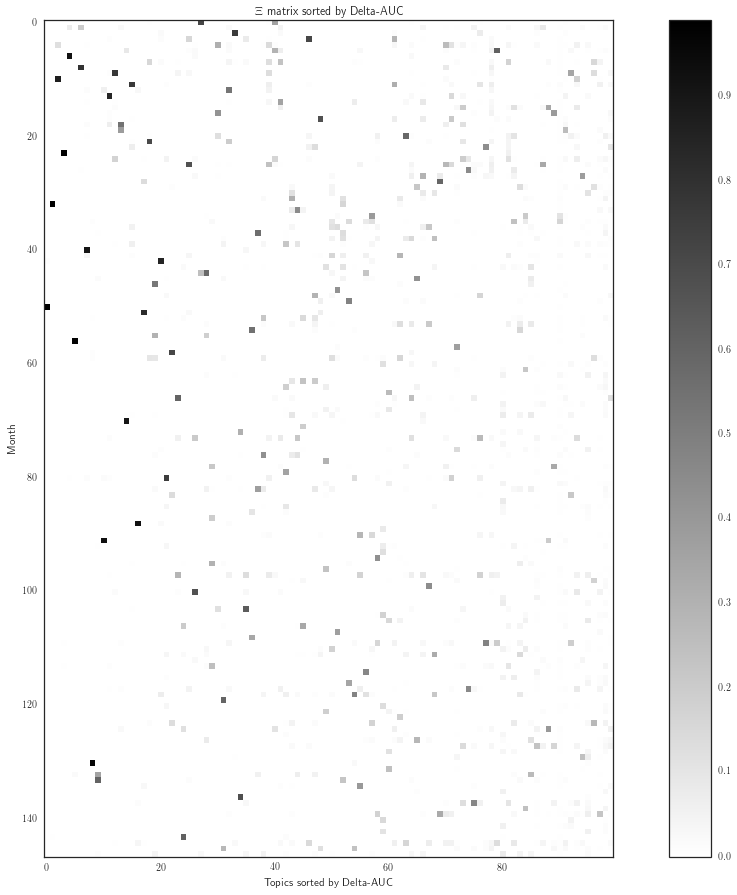

In [65]:
plot_matrix(phi_m[:, eventness_topicnums],
            xlabel='Topics sorted by Delta-AUC', ylabel='Month', title='$\Xi$ matrix sorted by Delta-AUC', save='Temporal_sorted_by_auc_Xi.eps')

In [75]:
eventness_topicnums[:10]

[9, 66, 28, 53, 52, 40, 0, 84, 45, 49]

In [85]:
topics[-10:]

[(0.6810680297139573, 93),
 (0.6989856015329492, 91),
 (0.71190983138672292, 29),
 (0.72884329888102128, 43),
 (0.73085693994613543, 95),
 (0.73216249793767929, 24),
 (0.75884214411043138, 58),
 (0.81226236689580633, 94),
 (0.83145635238249005, 60),
 (0.83155130584762516, 99)]

In [67]:
print_topics(eventness_topics)

@topic_9:  ambassador, question, report, state, material, right, facility, party, return, concern, fuel, government, answer, venezuela, reactor

@topic_66:  secretary, those, number, process, very, question, under, country, document, here, assistant, important, forward, brief, congress

@topic_28:  turkey, state, japan, investment, economic, unite, economy, trade, turkish, apec, vietnam, company, business, japanese, country

@topic_53:  very, minister, people, inaudible, president, here, important, prime, government, madame, opportunity, forward, help, future, secretary

@topic_52:  applause, woman, thank, family, child, life, here, help, many, more, world, today, every, honor, service

@topic_40:  egypt, egyptian, reform, democratic, more, secretary, election, process, support, president, security, need, those, term, very

@topic_0:  foreign, state, very, relationship, president, secretary, unite, thank, minister, meet, issue, security, much, together, discuss

@topic_84:  question, t

In [86]:
eventness_topicnums[-10:]

[93, 91, 29, 43, 95, 24, 58, 94, 60, 99]

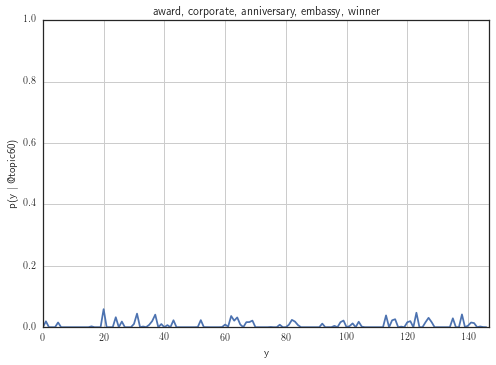

In [89]:
plot_pyt(phi_m, 60, title='award, corporate, anniversary, embassy, winner', save='nonevent1.eps')

In [768]:
phi_m = get_phi_timestamps(model)

In [769]:
phi_m.shape

(147, 100)

In [94]:
phi = model.get_phi(class_ids=[tokens_class]).values
corr_matrix = get_corr_matrix(phi).values

In [95]:
print_correlation_statistics(phi, params)

Min. Corr. 0.000768343969993
Max. Corr. 0.735068472011
Avg. Corr. 0.109839490532


(0.00076834396999314527, 0.73506847201112002, 0.10983949053179293)

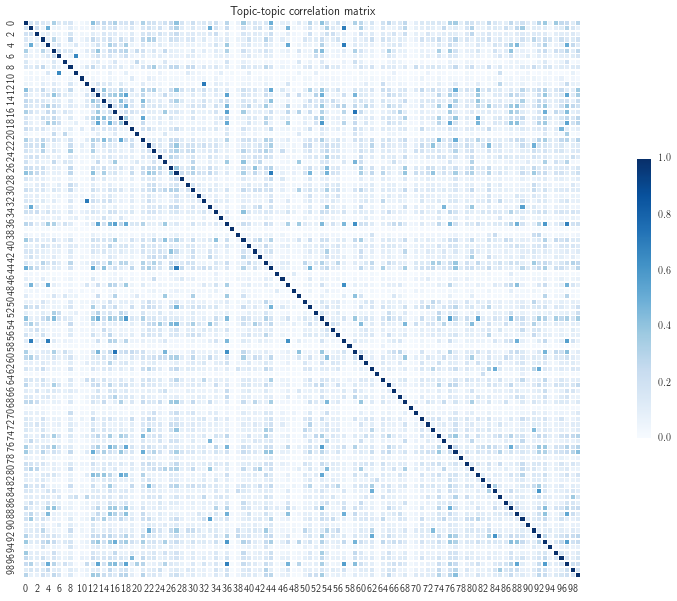

In [96]:
plot_corr_matrix(corr_matrix, save='LDA_corr.eps')

False


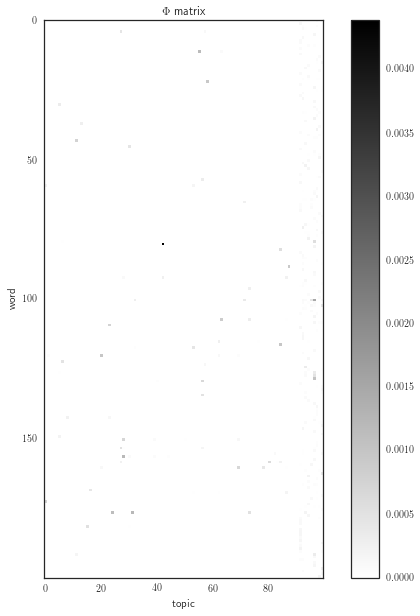

In [766]:
plot_matrix(phi[:200,:], figsize=(10,10), title="$\Phi$ matrix", xlabel='topic', ylabel='word', save='Temporal_Phi.eps')

False


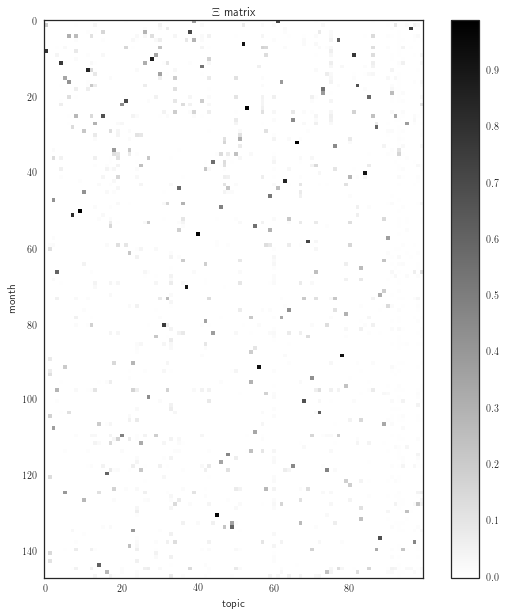

In [59]:
plot_matrix(phi_m, figsize=(10,10), title="$\Xi$ matrix", xlabel='topic', ylabel='month', save='Temporal_Xi.eps')

In [97]:
print_topics()

@topic_0:  relationship, state, president, foreign, indonesia, unite, security, secretary, respect, very, relation, indonesian, meet, visit, together

@topic_1:  question, state, information, department, answer, u.s., release, government, office, internet, view, public, contact, should, daily

@topic_2:  designate, under, state, entity, act, missile, designation, order, oil, control, ukraine, decision, pipeline, executive, sanction

@topic_3:  society, support, civil, tunisia, business, community, more, opportunity, help, reform, leader, world, country, east, middle

@topic_4:  question, inaudible, talk, mean, more, term, ambassador, don, kind, thing, those, people, actually, ask, country

@topic_5:  thank, remark, secretary, society, here, clinton, very, much, meet, today, civil, welcome, president, foreign, madam

@topic_6:  ambassador, king, morocco, mitchell, majesty, special, thank, corp, moroccan, visit, much, many, state, very, peace

@topic_7:  gate, defense, secretary, preside